In [7]:
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from dataset import CARLADataset
from data_preprocessing import preprocessing, transform_lidar_bev

# Prep & save to disk

In [133]:
path_data = os.path.join("..", "..", "data", "data")
# path_data = os.path.join("..", "..", "data", "data", "rr_dataset_23_11")
#path_data = os.path.join("..", "..", "data", "data_prep_npy")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

# Create Dataset & DataLoader
dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)


In [4]:
def rgb_to_disk(sensor, format):
    assert format in [".npy", ".npz"]
    fn_save = np.save if format == ".npy" else np.savez_compressed
    # save npy/ npz
    df_meta = dataset.df_meta_data
    for idx in tqdm(range(len(df_meta))):
        path_parts = dataset.df_meta_data["dir"][idx].split(os.sep)
        path_parts[path_parts.index("data") + 1] += "_prep_"
        dir_name_zip = os.path.join(*path_parts, "rgb")
        if not os.path.exists(dir_name_zip):
            os.makedirs(dir_name_zip)
            shutil.copytree(os.path.join(dataset.df_meta_data["dir"][idx], "measurements"), os.path.join(*path_parts, "measurements"))
        path = os.path.join(df_meta.iloc[idx][0], "rgb", df_meta.iloc[idx][1])
        img_np = dataset.load_data_from_path(path)
        img_torch = torch.Tensor(img_np)
        # img_torch_prep = preprocessing["rgb"](img_torch)
        # img_np_prep = img_torch_prep.numpy()
        filename_np = os.path.join(dir_name_zip, f"{df_meta.iloc[idx]['rgb'].split('.')[0]}{format}")
        # torch.save(img_torch_prep, filename_torch)
        with open(filename_np, 'wb') as f:
            fn_save(f, img_np)

In [134]:
# Saves preped data in same folder structure under rgb_prep
def rgb_to_disk_2(format):
    assert format in [".npy", ".npz", ".pt"]
    fn_save = np.save if format == ".npy" else np.savez_compressed
    # save npy/ npz
    df_meta = dataset.df_meta_data
    for idx in tqdm(range(len(df_meta))):
        path_parts = dataset.df_meta_data["dir"][idx].split(os.sep)
        # path_parts[path_parts.index("data") + 1] += "_prep_npy"
        dir_name_zip = os.path.join(*path_parts, "rgb_prep")
        if not os.path.exists(dir_name_zip):
            os.makedirs(dir_name_zip)
            # shutil.copytree(os.path.join(dataset.df_meta_data["dir"][idx], "measurements"), os.path.join(*path_parts, "measurements"))
        path = os.path.join(df_meta.iloc[idx][0], "rgb", df_meta.iloc[idx][1])
        img_np = dataset.load_data_from_path(path)
        img_torch = torch.Tensor(img_np)
        img_torch_prep = preprocessing["rgb"](img_torch)
        img_np_prep = img_torch_prep.numpy()
        filename_np = os.path.join(dir_name_zip, f"{df_meta.iloc[idx]['rgb'].split('.')[0]}{format}")
        # torch.save(img_torch_prep, filename_torch)
        with open(filename_np, 'wb') as f:
            fn_save(f, img_np_prep)

In [138]:
df_meta_data.loc[0]["dir"]

'../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town07_junction_Seed2000/non-straight-junction-Scen4_Town07_junction_route28_11_23_22_00_23'

In [135]:
rgb_to_disk_2(".npy")

  0%|          | 882/258816 [00:12<1:02:30, 68.76it/s]


KeyboardInterrupt: 

In [37]:
def lidar_transform_to_disk():
    # save npy/ npz
    df_meta = dataset.df_meta_data
    for idx in tqdm(range(len(df_meta))):
        dir_new = os.path.join(dataset.df_meta_data["dir"][idx], "lidar_prep")
        if not os.path.exists(dir_new):
            os.makedirs(dir_new)
        path_load = os.path.join(df_meta.iloc[idx][0], "lidar", df_meta.iloc[idx]["lidar"])
        lidar_np = dataset.load_data_from_path(path_load)
        lidar_transformed_np = preprocessing["lidar"](lidar_np)
        lidar_img = Image.fromarray(lidar_transformed_np)
        path_save = os.path.join(dir_new, f"{df_meta.iloc[idx]['lidar'].split('.')[0]}{'.png'}")
        lidar_img.save(path_save)

In [38]:
lidar_transform_to_disk()

  0%|          | 0/258816 [00:00<?, ?it/s]


KeyError: 'lidar'

In [5]:
lidar_transform_to_disk()

  0%|          | 798/258841 [00:06<36:47, 116.91it/s]


KeyboardInterrupt: 

# Loading the prep data

In [8]:
path_data = os.path.join("..", "..", "data", "data_prep")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

# Create Dataset & DataLoader
dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)


In [9]:
dataset.get_statistics()

,rgb_in_GB,measurements_in_GB,driving_time,%_of_entire_data
0,83.95,1.14,"1 day, 11:57:13",100.0


## Check speed: Loading .png and prep on fly

In [112]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }
# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

batch_size=64
# dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data.head(batch_size * 20), config=config_xy)
dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data.head(batch_size * 100), config=config_xy)
dl_prep = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, sampler=None)

In [113]:
# for x, y in tqdm(dl_prep):
#     x["rgb"] = preprocessing["rgb"](torch.squeeze(x["rgb"]))

In [114]:
for batch in tqdm(dl_prep):
    # batch
    rgb_prep = preprocessing["rgb"](torch.squeeze(batch["rgb"]))

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


## Check speed: Loading .npy (but unprep because when preped 1.8MB per file because float) and then prep
See if loading and .npy and preprocessing is still a lot faster than loading .png and preprocessing

In [115]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

batch_size=64
# dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data.head(batch_size * 20), config=config_xy)
dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data.head(batch_size * 100), config=config_xy)
dl_prep = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, sampler=None)

In [116]:
# for x, y in tqdm(dl_prep):
#     x["rgb"] = preprocessing["rgb"](torch.squeeze(x["rgb"]))

In [117]:
for batch in tqdm(dl_prep):
    # batch
    rgb_prep = preprocessing["rgb"](torch.squeeze(batch["rgb"]))

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


## Check speed: Loading .npy preped (high storage demand)

In [124]:
path_data = os.path.join("..", "..", "data", "data_prep_npy")
config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

batch_size=64
# dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data.head(batch_size * 20), config=config_xy)
dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data.head(batch_size * 100), config=config_xy)
dl_prep = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [126]:
df_meta_data

,dir,rgb,measurements
0,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0000.npy,0000.json
1,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0001.npy,0001.json
2,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0002.npy,0002.json
3,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0003.npy,0003.json
4,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0004.npy,0004.json
...,...,...,...
5395,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0052.npy,0052.json
5396,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0053.npy,0053.json
5397,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0054.npy,0054.json
5398,../../data/data_prep_npy/rr_dataset_23_11/Rout...,0055.npy,0055.json


In [125]:
for batch in tqdm(dl_prep):
    batch
    # rgb_prep = preprocessing["rgb"](torch.squeeze(batch["rgb"]))

100%|██████████| 85/85 [00:17<00:00,  4.88it/s]


In [102]:
batch["rgb"]

tensor([[[[[-0.8629, -0.3990, -0.5636,  ...,  0.5137,  0.3940,  0.2743],
           [ 0.5586,  0.4389,  0.3342,  ...,  0.5586,  0.4389,  0.3192],
           [ 0.6035,  0.4988,  0.3940,  ...,  0.7083,  0.6335,  0.6035],
           ...,
           [ 0.8280,  0.8130,  0.7083,  ..., -0.5636, -0.1297, -0.3990],
           [-0.5636,  0.1546,  0.0798,  ...,  0.7382,  1.1422,  0.9178],
           [-0.8629, -0.3990, -0.5636,  ...,  0.7831,  0.8280,  0.7232]],

          [[ 0.8891,  0.9057,  0.7892,  ..., -0.9911, -0.4753, -0.6584],
           [-0.6584,  0.1569, -0.0094,  ...,  0.9889,  1.8708,  1.5546],
           [-0.9911, -0.4753, -0.7249,  ...,  0.8724,  0.9723,  0.8558],
           ...,
           [ 0.9723,  1.9540,  1.7044,  ...,  0.9723,  2.0039,  1.7044],
           [-0.6584, -0.0760, -0.2590,  ...,  1.7876,  1.8874,  2.0039],
           [ 1.8375,  1.9207,  2.0371,  ...,  0.8724,  1.7876,  1.6711]],

          [[ 0.5041,  1.3045,  1.2139,  ...,  0.5041,  1.5159,  1.1535],
           [-0.

# Test LiDAR transform

In [5]:
path = "/Users/julianvonklitzing/Documents/GitHub/end2endappras/data/data/coke_dataset_23_11/Routes_Scenario3_Town01_curved_Seed1000/Scenario3_Town01_curved_route0_11_23_20_02_59/lidar/0000.npy"

In [20]:
np.load(path, allow_pickle=True).shape == (2, )

True

In [15]:
img_lidar_np = transform_lidar_bev(np.load(path, allow_pickle=True)[1])

In [10]:
import matplotlib.pyplot as plt

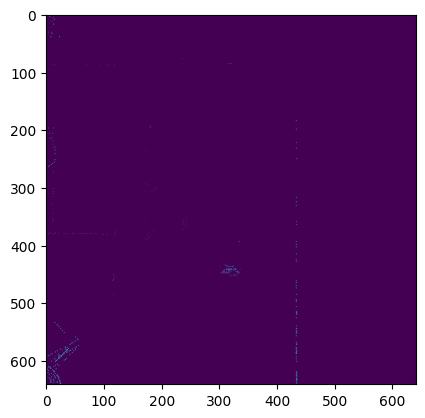

In [17]:
plt.imshow(img_lidar)

In [16]:
from PIL import Image
im = Image.fromarray(img_lidar_np)
im.save("your_file.png")